<a href="https://colab.research.google.com/github/atpathak/DeepLearning_code-templates_2026/blob/main/CNN_Jet_Images_Demo1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install uproot
!pip install h5py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.8/393.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.7/913.7 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 656.7/656.7 kB 22.1 MB/s eta 0:00:00


Load numpy arrays

Now let's implement a CNN using Keras. Here, we load the numpy arrays containing the 4D tensors of "jet-images".

In [ ]:
import h5py

h5f = h5py.File("jet_images.h5", "r")

jet_images_dict = {}
jet_images_dict["QCD"] = h5f["QCD"][()]
jet_images_dict["TT"] = h5f["TT"][()]

h5f.close()

In [ ]:
print(jet_images_dict["QCD"].shape)
print(jet_images_dict["TT"].shape)

(3305, 30, 30, 1)
(1722, 30, 30, 1)


**Plotting jet-images**

Let's plot some jet-images (individual jets and averaged over all jets)

Question 1: Try to plot the average W and QCD jet-images.

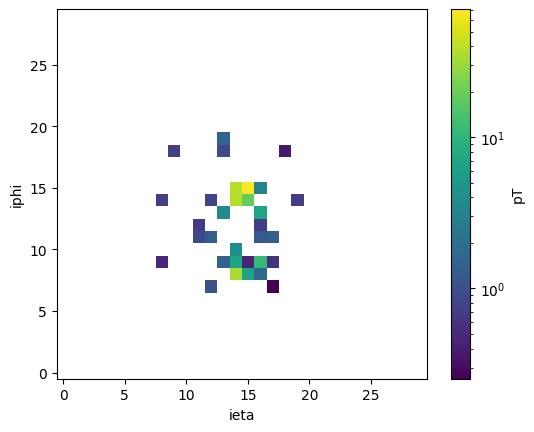

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

%matplotlib inline

# plot one W jet
i = 7
plt.figure("W")
plt.imshow(
    jet_images_dict["TT"][i, :, :, 0].T,
    norm=mpl.colors.LogNorm(),
    origin="lower",
    interpolation="none",
)
cbar = plt.colorbar()
cbar.set_label("pT")
plt.xlabel("ieta")
plt.ylabel("iphi")
plt.show()

# plot average W jet

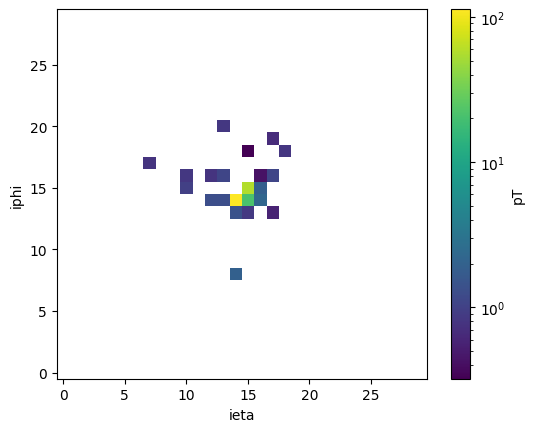

In [ ]:
# plot one QCD jet
i = 7
plt.figure()
plt.imshow(
    jet_images_dict["QCD"][i, :, :, 0].T,
    norm=mpl.colors.LogNorm(),
    origin="lower",
    interpolation="none",
)
cbar = plt.colorbar()
cbar.set_label("pT")
plt.xlabel("ieta")
plt.ylabel("iphi")
plt.show()

# plot average QCD jet

**Define our convolutional model**

Question 2: Here we have a relatively simple Conv2D model using regularization, batch normalization, max pooling, and a fully connected layer before the ouput. Compare the performance and number of parameters when using fully connected layers instead of convolutional layers.

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    Dense,
    BatchNormalization,
    Concatenate,
)
from tensorflow.keras.regularizers import l1, l2

nx = 30
ny = 30
inputs = Input(shape=(nx, ny, 1), name="input")
x = Conv2D(
    filters=8,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    activation="relu",
    name="conv2d_1",
    kernel_regularizer=l2(0.01),
)(inputs)
x = BatchNormalization(momentum=0.6, name="batchnorm_1")(x)
x = MaxPool2D(pool_size=(2, 2), name="maxpool2d_1")(x)
x = Flatten(name="flatten")(x)
x = Dense(64, activation="relu", name="dense")(x)
outputs = Dense(1, activation="sigmoid", name="output")(x)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 30, 30, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 30, 30, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 15, 15, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       115,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,441 (450.94 KB)

 Trainable params: 115,425 (450.88 KB)

 Non-trainable params: 16 (64.00 B)

Dividing the data into testing and training dataset

We will split the data into two parts (one for training+validation and one for testing). Note: We will not apply "image normalization" preprocessing: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html.

In [ ]:
jet_images = np.concatenate([jet_images_dict["TT"], jet_images_dict["QCD"]])
jet_labels = np.concatenate(
    [np.ones(len(jet_images_dict["TT"])), np.zeros(len(jet_images_dict["QCD"]))]
)

X = jet_images
Y = jet_labels

from sklearn.model_selection import train_test_split

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

print("number of W jets for training/validation: %i" % np.sum(Y_train_val == 1))
print("number of QCD jets for training/validation: %i" % np.sum(Y_train_val == 0))

print("number of W jets for testing: %i" % np.sum(Y_test == 1))
print("number of QCD jets for testing: %i" % np.sum(Y_test == 0))

# early stopping callback
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor="val_loss", patience=10)

# model checkpoint callback
# this saves our model architecture + parameters into conv2d_model.h5
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(
    "conv2d_model.h5",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
)

number of W jets for training/validation: 1384
number of QCD jets for training/validation: 2637
number of W jets for testing: 338
number of QCD jets for testing: 668


In [ ]:
# Train classifier
history = model.fit(
    X_train_val,
    Y_train_val,
    epochs=100,
    batch_size=1024,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint],
    validation_split=0.25,
)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.3248 - loss: 1.8220

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 526ms/step - accuracy: 0.3453 - loss: 1.7191 - val_accuracy: 0.6720 - val_loss: 0.7939
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.6896 - loss: 0.7645

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 423ms/step - accuracy: 0.6928 - loss: 0.7527 - val_accuracy: 0.8012 - val_loss: 0.4751
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.8242 - loss: 0.4211

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 416ms/step - accuracy: 0.8302 - loss: 0.4122 - val_accuracy: 0.8757 - val_loss: 0.4028
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 410ms/step - accuracy: 0.8929 - loss: 0.3708 - val_accuracy: 0.8797 - val_loss: 0.4682
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 400ms/step - accuracy: 0.8883 - loss: 0.4081 - val_accuracy: 0.8857 - val_loss: 0.4130
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 429ms/step - accuracy: 0.9025 - loss: 0.3423 - val_accuracy: 0.8797 - val_loss: 0.4030
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step - accuracy: 0.9002 - loss: 0.3341 - val_accuracy: 0.8708 - val_loss: 0.4171
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 430ms/step - accuracy: 0.8872 - loss: 0.3584 - val_accuracy: 0.8728 - val_loss: 0.4058
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.8924 - loss: 0.3344

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 421ms/step - accuracy: 0.8924 - loss: 0.3330 - val_accuracy: 0.8857 - val_loss: 0.3797
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.9052 - loss: 0.2923

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 430ms/step - accuracy: 0.9044 - loss: 0.2969 - val_accuracy: 0.8917 - val_loss: 0.3690
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.9095 - loss: 0.3005

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 429ms/step - accuracy: 0.9088 - loss: 0.3019 - val_accuracy: 0.8966 - val_loss: 0.3649
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.9116 - loss: 0.2911

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 429ms/step - accuracy: 0.9107 - loss: 0.2935 - val_accuracy: 0.8907 - val_loss: 0.3538
Epoch 13/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9081 - loss: 0.3064

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 427ms/step - accuracy: 0.9082 - loss: 0.3027 - val_accuracy: 0.8827 - val_loss: 0.3466
Epoch 14/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.9043 - loss: 0.2746

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 418ms/step - accuracy: 0.9039 - loss: 0.2773 - val_accuracy: 0.8817 - val_loss: 0.3429
Epoch 15/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.9043 - loss: 0.2726

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 426ms/step - accuracy: 0.9039 - loss: 0.2746 - val_accuracy: 0.8837 - val_loss: 0.3353
Epoch 16/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.9070 - loss: 0.2698

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 796ms/step - accuracy: 0.9066 - loss: 0.2714 - val_accuracy: 0.8857 - val_loss: 0.3311
Epoch 17/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9102 - loss: 0.2730

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 489ms/step - accuracy: 0.9100 - loss: 0.2731 - val_accuracy: 0.8847 - val_loss: 0.3274
Epoch 18/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.9078 - loss: 0.2662

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 428ms/step - accuracy: 0.9077 - loss: 0.2671 - val_accuracy: 0.8837 - val_loss: 0.3251
Epoch 19/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.9108 - loss: 0.2558

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 436ms/step - accuracy: 0.9101 - loss: 0.2582 - val_accuracy: 0.8817 - val_loss: 0.3228
Epoch 20/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9068 - loss: 0.2655

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 422ms/step - accuracy: 0.9072 - loss: 0.2648 - val_accuracy: 0.8817 - val_loss: 0.3207
Epoch 21/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.9051 - loss: 0.2657

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 425ms/step - accuracy: 0.9061 - loss: 0.2642 - val_accuracy: 0.8827 - val_loss: 0.3186
Epoch 22/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.9072 - loss: 0.2633

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 421ms/step - accuracy: 0.9082 - loss: 0.2616 - val_accuracy: 0.8817 - val_loss: 0.3174
Epoch 23/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.9146 - loss: 0.2459

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 408ms/step - accuracy: 0.9141 - loss: 0.2478 - val_accuracy: 0.8827 - val_loss: 0.3161
Epoch 24/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.9153 - loss: 0.2469

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 424ms/step - accuracy: 0.9148 - loss: 0.2480 - val_accuracy: 0.8827 - val_loss: 0.3153
Epoch 25/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.9165 - loss: 0.2389

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 741ms/step - accuracy: 0.9159 - loss: 0.2413 - val_accuracy: 0.8807 - val_loss: 0.3131
Epoch 26/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9166 - loss: 0.2420

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 494ms/step - accuracy: 0.9161 - loss: 0.2429 - val_accuracy: 0.8847 - val_loss: 0.3117
Epoch 27/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.9166 - loss: 0.2466

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 407ms/step - accuracy: 0.9164 - loss: 0.2457 - val_accuracy: 0.8827 - val_loss: 0.3105
Epoch 28/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9158 - loss: 0.2455

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 435ms/step - accuracy: 0.9160 - loss: 0.2443 - val_accuracy: 0.8817 - val_loss: 0.3096
Epoch 29/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.9151 - loss: 0.2446

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 415ms/step - accuracy: 0.9155 - loss: 0.2431 - val_accuracy: 0.8827 - val_loss: 0.3084
Epoch 30/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.9136 - loss: 0.2400

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 418ms/step - accuracy: 0.9148 - loss: 0.2391 - val_accuracy: 0.8837 - val_loss: 0.3078
Epoch 31/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.9199 - loss: 0.2283

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 438ms/step - accuracy: 0.9193 - loss: 0.2297 - val_accuracy: 0.8837 - val_loss: 0.3073
Epoch 32/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9194 - loss: 0.2273

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 417ms/step - accuracy: 0.9187 - loss: 0.2284 - val_accuracy: 0.8827 - val_loss: 0.3071
Epoch 33/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.9152 - loss: 0.2353

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 438ms/step - accuracy: 0.9157 - loss: 0.2341 - val_accuracy: 0.8837 - val_loss: 0.3070
Epoch 34/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.9176 - loss: 0.2272

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 763ms/step - accuracy: 0.9176 - loss: 0.2273 - val_accuracy: 0.8857 - val_loss: 0.3064
Epoch 35/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9178 - loss: 0.2226

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 437ms/step - accuracy: 0.9179 - loss: 0.2235 - val_accuracy: 0.8867 - val_loss: 0.3062
Epoch 36/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.9175 - loss: 0.2262

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 435ms/step - accuracy: 0.9177 - loss: 0.2256 - val_accuracy: 0.8837 - val_loss: 0.3061
Epoch 37/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.9192 - loss: 0.2197

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 435ms/step - accuracy: 0.9193 - loss: 0.2203 - val_accuracy: 0.8867 - val_loss: 0.3059
Epoch 38/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.9203 - loss: 0.2184

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 419ms/step - accuracy: 0.9202 - loss: 0.2188 - val_accuracy: 0.8887 - val_loss: 0.3051
Epoch 39/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 392ms/step - accuracy: 0.9217 - loss: 0.2190 - val_accuracy: 0.8857 - val_loss: 0.3055
Epoch 40/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 408ms/step - accuracy: 0.9210 - loss: 0.2128 - val_accuracy: 0.8867 - val_loss: 0.3054
Epoch 41/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 407ms/step - accuracy: 0.9220 - loss: 0.2113 - val_accuracy: 0.8877 - val_loss: 0.3055
Epoch 42/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.9220 - loss: 0.2141

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 415ms/step - accuracy: 0.9219 - loss: 0.2137 - val_accuracy: 0.8867 - val_loss: 0.3050
Epoch 43/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.9201 - loss: 0.2135

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 667ms/step - accuracy: 0.9207 - loss: 0.2128 - val_accuracy: 0.8867 - val_loss: 0.3046
Epoch 44/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 427ms/step - accuracy: 0.9255 - loss: 0.2050 - val_accuracy: 0.8867 - val_loss: 0.3058
Epoch 45/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 406ms/step - accuracy: 0.9261 - loss: 0.2041 - val_accuracy: 0.8877 - val_loss: 0.3065
Epoch 46/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 396ms/step - accuracy: 0.9282 - loss: 0.2022 - val_accuracy: 0.8847 - val_loss: 0.3063
Epoch 47/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 408ms/step - accuracy: 0.9238 - loss: 0.2067 - val_accuracy: 0.8857 - val_loss: 0.3051
Epoch 48/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 409ms/step - accuracy: 0.9254 - loss: 0.2068 - val_accuracy: 0.8887 - val_loss: 0.3059
Epoch 49/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 420ms/step - accuracy: 0.9264 - loss: 0.2050 - val_accuracy: 0.8857 - val_loss: 0.3076
Epoch 50/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 407ms/step - accuracy: 0.9290 - loss: 0.2042 - val_accuracy: 0.8857 - val_lo

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


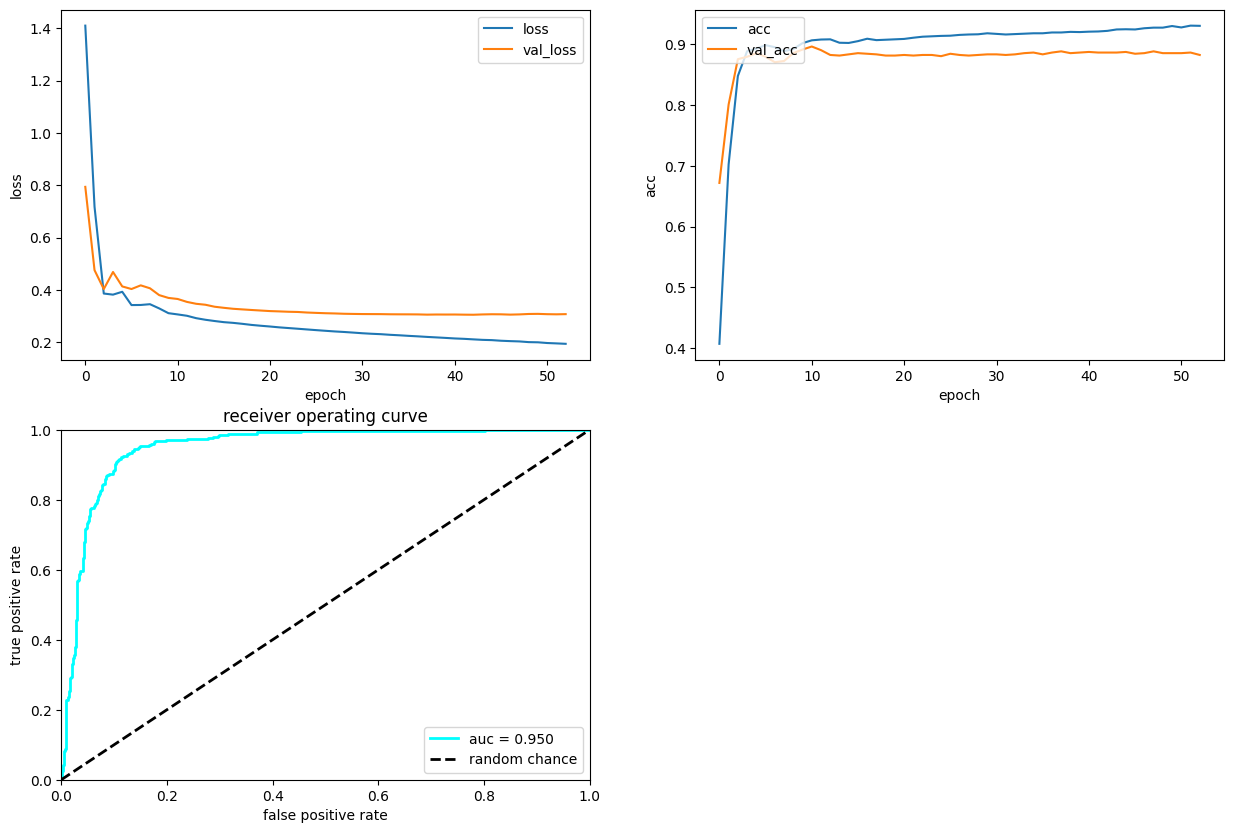

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
# plot loss vs epoch
plt.figure(figsize=(15, 10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history["loss"], label="loss")
ax.plot(history.history["val_loss"], label="val_loss")
ax.legend(loc="upper right")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")

# plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
ax.plot(history.history["accuracy"], label="acc")
ax.plot(history.history["val_accuracy"], label="val_acc")
ax.legend(loc="upper left")
ax.set_xlabel("epoch")
ax.set_ylabel("acc")

# Plot ROC
Y_predict = model.predict(X_test)
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
ax = plt.subplot(2, 2, 3)
ax.plot(fpr, tpr, lw=2, color="cyan", label="auc = %.3f" % (roc_auc))
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="k", label="random chance")
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.set_xlabel("false positive rate")
ax.set_ylabel("true positive rate")
ax.set_title("receiver operating curve")
ax.legend(loc="lower right")
plt.show()